<font size="5"><p style="text-align:center;">Titanic: Machine Learning model </p></font>    
<font size="5">Name: Eliran Shmueli (Malichy)</font>  
<font size="5">link: https://www.kaggle.com/eliranmalichy</font>  


<font size="4">In this exercise I'm going to predict who is going to survive the Titanic disaster by using the available dataset.  
    In order to do that I'm going to:</font>  
* <font size="4">read the data file. </font>
* <font size="4"> use data cleansing. </font>
* <font size="4"> analyze to data. </font>
* <font size="4"> create parameters and hyper parameters. </font>
* <font size="4"> create a logistic regression model. </font>  
<font size="4">Assumption: the people with the most chance to survive are: women, children and first-class passengers. </font>  



In [1]:
#!pip install --upgrade plotly
#!pip install sweetviz

In [2]:
## imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rnd
import os
import seaborn as sns
import sklearn
import plotly.graph_objects as go
import plotly.express as px

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
## functions

def printL(str):
    print(str,"\n\n")
    
def replace_titles_to_rare(dataset):
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
def replace_titles(dataset):
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

def drop_ticket(dataset):
    dataset = dataset.drop('Ticket', axis=1)
    return dataset

def create_hyper_fare_Pclass(dataset):
    return dataset['Fare']/dataset['Pclass']

def create_hyper_age_range(dataset):
    if(dataset['Age'] <= 16):
        return 0
    if(dataset['Age'] > 16) & (dataset['Age'] <= 32):
        return 1
    if (dataset['Age'] > 32) & (dataset['Age'] <= 48):
        return 2
    if (dataset['Age'] > 48) & (dataset['Age'] <= 64):
        return 3
    if (dataset['Age'] > 64):
        return 4
    
def extract_title(dataset):
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

def convert_categorical_titles_to_ordinal(dataset,mapping):
    dataset['Title'] = dataset['Title'].map(mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

def convert_sex_strings_to_numerical(dataset):
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
def guess_values_age_Pclass(dataset):
    guess_ages = np.zeros((2,3))
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5      
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]
    dataset['Age'] = dataset['Age'].astype(int)    
    
def process_family(df):
    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df

def create_heatmap_graph(dataset):
    plt.figure(figsize=(13,13))
    cor = np.abs(dataset.corr())
    sns.heatmap(cor, annot=True, cmap=plt.cm.Blues, vmin=-1, vmax=1)
    plt.show()
    
def create_grid(col,row,feature):
    grid = sns.FacetGrid(data_train, col = col, row = row, height=2.2, aspect=1.6)
    grid.map(plt.hist, feature, bins=20)
    
def process_cabin(df):  
    cabin_dic={}
    count=0
    # replacing missing cabins with U (for Uknown)
    df.Cabin.fillna('T', inplace=True)
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    for letter in df['Cabin']:
        letter_num = cabin_dic.get(letter)
        if(letter_num==None):
            cabin_dic[letter] = count
            count=count+1
    df['Cabin'] = df['Cabin'].map(cabin_dic).astype(int)
    return df

def check_for_empty_values(data_train,data_test):
    ## check if there are missing values
    print("Data training:\n")
    printL(data_train.isna().any())
    print("Data test:\n")
    printL(data_test.isna().any())
    
def refill_empty_values(dataset,freq_port): 
    guess_values_age_Pclass(dataset)
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset=process_cabin(dataset)
    dataset = drop_ticket(dataset) 
    return dataset
    
def add_hypers(dataset):
    dataset['Fare_divided_by_Pclass'] = dataset.apply(create_hyper_fare_Pclass, axis = 1)
    dataset['Age_range'] = dataset.apply(create_hyper_age_range, axis = 1)
    dataset=process_family(dataset)
    return dataset    

def get_cv_score_and_loss(X, t, model, transformer=None, k=None, p=None, show_score_loss_graphs=False, use_pbar=True):
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
    elif p is not None:
        cv = LeavePOut(p)
    else:
        raise ValueError('you need to specify k or p in order for the cv to work')

    if use_pbar:
        pbar = tqdm(desc='Computing Models',
                    total=find_generator_len(cv.split(X)))

    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.loc[train_ids]
        t_train = t.loc[train_ids]
        X_val = X.loc[val_ids]
        t_val = t.loc[val_ids]

        model.fit(X_train, t_train)

        y_train = model.predict(X_train)
        y_val = model.predict(X_val)
        scores_losses_df.loc[len(scores_losses_df)] =\
         [i, 'train', model.score(X_train, t_train),
          mean_squared_error(t_train, y_train)]
        scores_losses_df.loc[len(scores_losses_df)] =\
         [i, 'val', model.score(X_val, t_val), mean_squared_error(t_val, y_val)]

        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    val_scores_losses_df = scores_losses_df[scores_losses_df['split']=='val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split']=='train']

    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    if show_score_loss_graphs:
        fig = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        fig.show()
        fig = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Mean Val Loss: {mean_val_loss:.2f}, Mean Train Loss: {mean_train_loss:.2f}')
        fig.show()

    return mean_val_score, mean_val_loss,mean_train_score, mean_train_loss

def evaulate(x,y,model,model_name):
    val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(x, y, model, k=30, show_score_loss_graphs=True)
    print("Model: ",model_name)
    print(f'Mean cv val score: {val_score:.2f}\nMean cv val loss {val_loss:.2f}')
    print(f'Mean cv train val score: {train_score:.2f}\nMean cv train val loss {train_loss:.2f}')
    
def rec_feat_selection(X, t):
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    all_cols = list(categorical_cols) + list(numerical_cols)
    ct_enc_std = ColumnTransformer([
              ("encoding", OrdinalEncoder(), categorical_cols),
              ("standard", StandardScaler(), numerical_cols)])
    X_encoded = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)

    selector = RFECV(SGDRegressor(random_state=1), cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)).fit(X_encoded, t)
    display(X_encoded.loc[:, selector.support_])

    fig = go.Figure()
    results = selector.cv_results_['mean_test_score'] # Getting the mean cv score for each set of features
    fig.add_trace(go.Scatter(x=[i for i in range(1, len(results) + 1)], y=results))
    fig.update_xaxes(title_text="Number of features selected")
    fig.update_yaxes(title_text="Cross validation score (nb of correct classifications)")
    fig.show()

    return X_encoded.loc[:, selector.support_]     

def find_generator_len(generator, use_pbar=True):
    i = 0
    
    if use_pbar:
        pbar = tqdm(desc='Calculating Length',
                    ncols=1000,
                    bar_format='{desc}{bar:10}{r_bar}')

    for a in generator:
        i += 1

        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    return i    

def check_model(model,X_train,y_train,X_test,model_name):
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    print('--------------The Accuracy of the', model_name,'----------------------------')
    print('The accuracy is',round(accuracy_score(prediction,y_test)*100,2))
    kfold = KFold(n_splits=10, random_state=42, shuffle=True) # k=10, split the data into 10 equal parts
    result_model=cross_val_score(model,x_train_all,y_train_all,cv=kfold,scoring='accuracy')
    print('The cross validated score is:',round(result_model.mean()*100,2))
    y_pred = cross_val_predict(model,x_train_all,y_train_all,cv=kfold)
    sns.heatmap(confusion_matrix(y_train_all,y_pred),annot=True,fmt='3.0f',cmap="summer")
    plt.title('Confusion_matrix', y=1.05, size=15)
    
# show graph of score and loss by plynomial degree of numerical features
def show_degree_graphs_cv_train(X, t, model, k=None, p=None, max_degree=10):
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
    ct = ColumnTransformer([
    ("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols),
    ("standard", StandardScaler(), numerical_cols)])
    
    val_train_score_loss_df = pd.DataFrame(columns=['degree', 'split', 'score', 'loss'])
    for i in tqdm(range(1, max_degree), desc='Poly Degree'):
        ct_enc_std_poly = ColumnTransformer([
            ("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols),
            ("standard_poly", make_pipeline(PolynomialFeatures(degree=i), StandardScaler()), numerical_cols)])
        model_pipe = make_pipeline(ct_enc_std_poly, model)
        val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X, t, model_pipe, transformer=ct, k=k, p=p, show_score_loss_graphs=False, use_pbar=False)
        val_train_score_loss_df.loc[len(val_train_score_loss_df)] = [i, 'train', train_score, train_loss]
        val_train_score_loss_df.loc[len(val_train_score_loss_df)] = [i, 'cv', val_score, val_loss]

    fig = px.line(val_train_score_loss_df, x='degree', y='score', color='split')
    fig.show()
    fig = px.line(val_train_score_loss_df, x='degree', y='loss', color='split')
    fig.show()

 

In [4]:
## get and copy data
data_train = pd.read_csv('../input/titanic/train.csv')
data_test = pd.read_csv('../input/titanic/test.csv')
data_test_temp = data_test.copy()
data_train_temp = data_train.copy()
data_test_passenger_id= data_test_temp['PassengerId']

<font size="5">Essential data analysis</font>  

In [5]:
display(data_train_temp.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
## check data for unique values 
data_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [7]:
## check for data type
print("Data training:\n")
printL(data_train.info())
print("Data test:\n")
printL(data_test.info())

Data training:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 


Data test:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  4

In [8]:
convert_sex_strings_to_numerical(data_train_temp)
convert_sex_strings_to_numerical(data_test_temp)

In [9]:
check_for_empty_values(data_train_temp,data_test_temp)

Data training:

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool 


Data test:

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool 




In [10]:
## Data Cleansing
freq_port = data_train_temp.Embarked.dropna().mode()[0]
data_train_temp = refill_empty_values(data_train_temp,freq_port)
data_test_temp = refill_empty_values(data_test_temp,freq_port)
data_test_temp['Fare'].fillna(data_test_temp['Fare'].dropna().median(), inplace=True)

In [11]:
check_for_empty_values(data_train_temp,data_test_temp)

Data training:

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked       False
dtype: bool 


Data test:

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked       False
dtype: bool 




In [12]:
## Analyze Pclass feature with survived
display(data_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
## Analyze sex feature with survived
display(data_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
## Analyze SibSp feature with survived
display(data_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
## Analyze Parch feature with survived
display(data_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


,Sex,Survived
0,female,0.742038
1,male,0.188908


,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


<font size="5">Graphs:</font>  

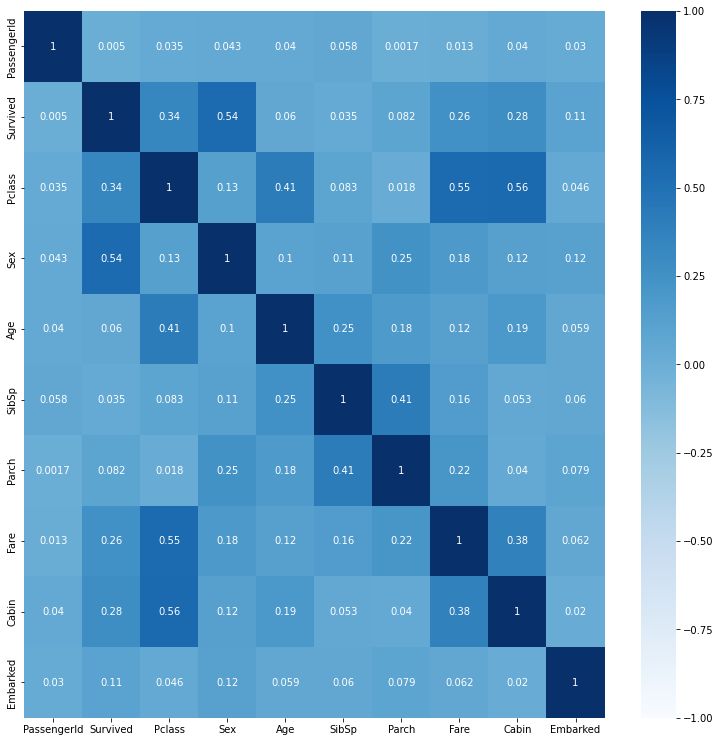

In [13]:
create_heatmap_graph(data_train_temp)

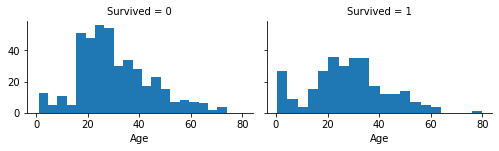

In [14]:
create_grid('Survived',None,'Age')

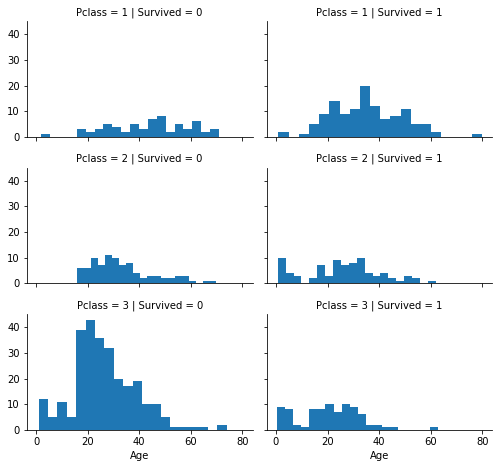

In [15]:
create_grid('Survived','Pclass','Age')

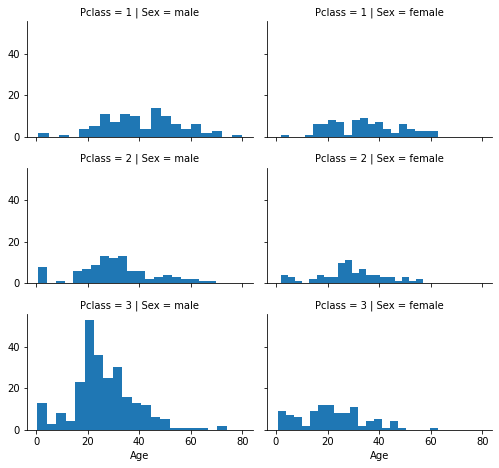

In [16]:
create_grid('Sex','Pclass','Age')

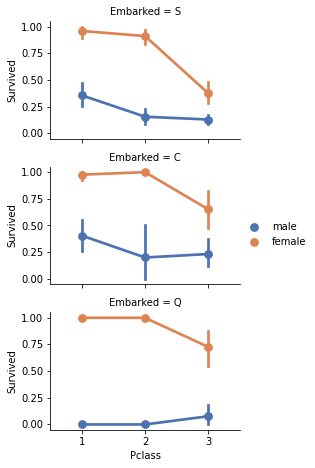

In [17]:
grid = sns.FacetGrid(data_train, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep',order = [1,2,3], hue_order = ['male','female'])
grid.add_legend();

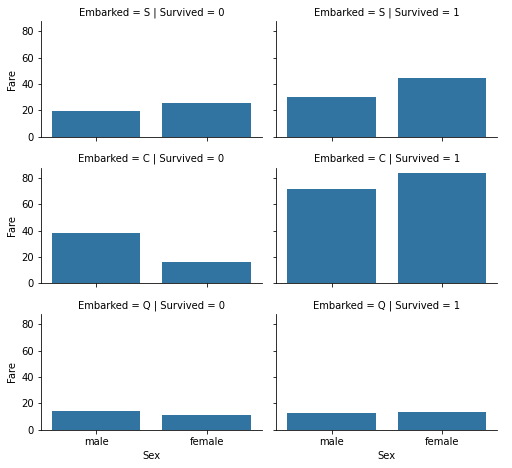

In [18]:
grid = sns.FacetGrid(data_train, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', ci=None,order = ['male','female'])
grid.add_legend();

<font size="5">Creating parameters:</font>  

In [19]:
extract_title(data_train_temp)
extract_title(data_test_temp)
pd.crosstab(data_train_temp['Title'], data_train_temp['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [20]:
replace_titles_to_rare(data_train_temp)
replace_titles_to_rare(data_test_temp)
replace_titles(data_train_temp)
replace_titles(data_test_temp)

data_train_temp[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [21]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
convert_categorical_titles_to_ordinal(data_train_temp,title_mapping) 
convert_categorical_titles_to_ordinal(data_test_temp,title_mapping) 
data_train_temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,0,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,1,0,3
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,0,0,1


In [22]:
data_train_temp = data_train_temp.drop(['Name', 'PassengerId'], axis=1)
data_test_temp = data_test_temp.drop(['Name'], axis=1)

In [23]:
## creating hyper parametares
add_hypers(data_train_temp)
add_hypers(data_test_temp)
data_train_temp

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Fare_divided_by_Pclass,Age_range,FamilySize,Singleton,SmallFamily,LargeFamily
0,0,3,0,22,1,0,7.2500,0,0,1,2.416667,1,2,0,1,0
1,1,1,1,38,1,0,71.2833,1,1,3,71.283300,2,2,0,1,0
2,1,3,1,26,0,0,7.9250,0,0,2,2.641667,1,1,1,0,0
3,1,1,1,35,1,0,53.1000,1,0,3,53.100000,2,2,0,1,0
4,0,3,0,35,0,0,8.0500,0,0,1,2.683333,2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27,0,0,13.0000,0,0,5,6.500000,1,1,1,0,0
887,1,1,1,19,0,0,30.0000,6,0,2,30.000000,1,1,1,0,0
888,0,3,1,21,1,2,23.4500,0,0,2,7.816667,1,4,0,1,0
889,1,1,0,26,0,0,30.0000,1,1,1,30.000000,1,1,1,0,0


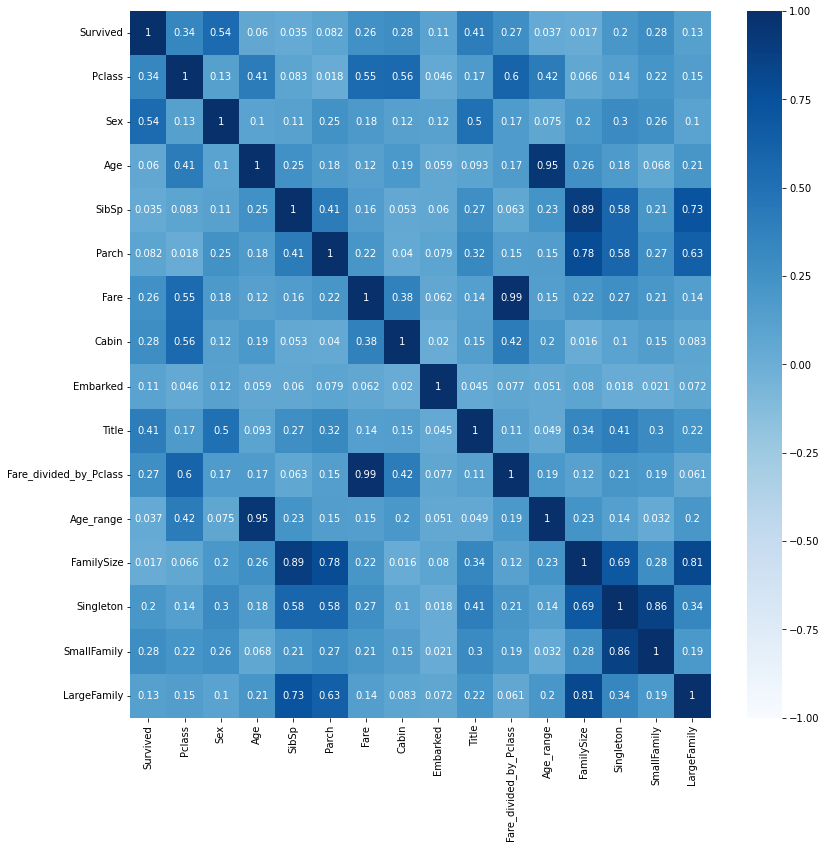

In [24]:
create_heatmap_graph(data_train_temp)

<font size="5">Summary:</font>  
<font size="4">By analyzing the dataset with graph and grids, I saw that my assumption is correct.  
I created the following hyper parameters:</font>   
* <font size="4">Family size classification</font>  
* <font size="4">Age classification</font>  
* <font size="4">Connection between the ticket and the price</font>
 </font>


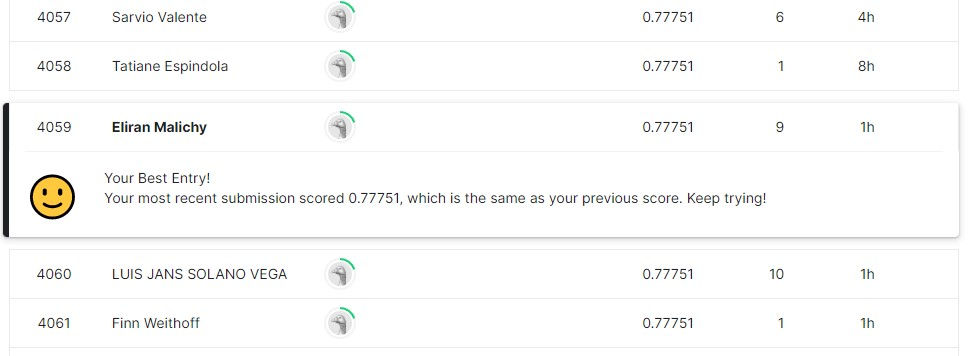

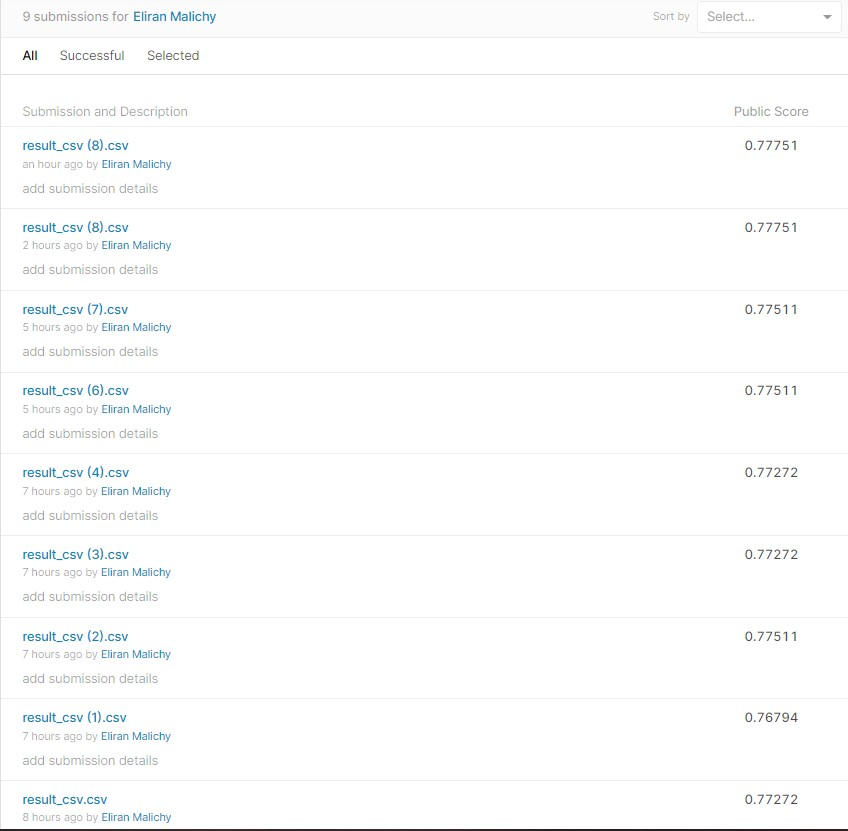

<font size="5">Exercise 3:</font>  


<font size="4">In this exercise I'm going to try to improve my score from exercise 1, by doing to the following things:</font>  
* <font size="4">Create models. </font>
* <font size="4">Evaulate models. </font>
* <font size="4"> Finding the best subset of features for this dataset. </font>
* <font size="4"> Finding the best hyper parameters for the chosen model. </font> 

<font size="4">Remarks: I understand from the instruction of this exercise, that it is allowed to use only the following models: KNN, NBC or LDA. </font>  



In [25]:
x_train_all = data_train_temp.drop(["Survived","SibSp","Parch"], axis=1)
y_train_all = data_train_temp["Survived"]
x_test_final  = data_test_temp.drop(["PassengerId","SibSp","Parch"], axis=1).copy()
X_train,X_test,y_train,y_test = train_test_split(x_train_all, y_train_all, test_size=0.3, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 13), (268, 13), (623,), (268,))

<font size="5">Create models</font>

In [26]:
KNN_model = KNeighborsClassifier(n_neighbors = 4)

NBC_model= GaussianNB()

LDA_model= LinearDiscriminantAnalysis()

<font size="5">Evaulate models</font>

# <font size="4">KNN model</font>

--------------The Accuracy of the KNN model ----------------------------
The accuracy is 69.78
The cross validated score is: 72.38


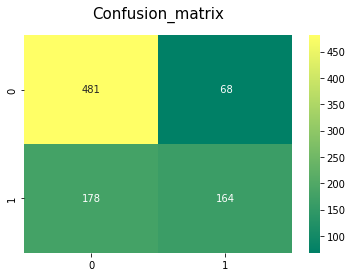

In [27]:
check_model(KNN_model,X_train,y_train,X_test,'KNN model')

In [28]:
evaulate(x_train_all, y_train_all,KNN_model,"KNN model")

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/30 [00:00<?, ?it/s]

Model:  KNN model
Mean cv val score: 0.73
Mean cv val loss 0.27
Mean cv train val score: 0.82
Mean cv train val loss 0.18


In [29]:
show_degree_graphs_cv_train(x_train_all, y_train_all,KNN_model, k=5 ,max_degree=8)   

Poly Degree:   0%|          | 0/7 [00:00<?, ?it/s]

# <font size="4">NBC model</font>

--------------The Accuracy of the NBC model ----------------------------
The accuracy is 77.61
The cross validated score is: 76.21


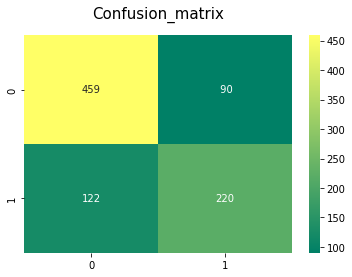

In [30]:
check_model(NBC_model,X_train,y_train,X_test,'NBC model')

In [31]:
evaulate(x_train_all, y_train_all,NBC_model,"NBC model")

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/30 [00:00<?, ?it/s]

Model:  NBC model
Mean cv val score: 0.76
Mean cv val loss 0.24
Mean cv train val score: 0.77
Mean cv train val loss 0.23


In [32]:
show_degree_graphs_cv_train(x_train_all, y_train_all,NBC_model, k=5 ,max_degree=8) 

Poly Degree:   0%|          | 0/7 [00:00<?, ?it/s]

# <font size="4">LDA model</font>

--------------The Accuracy of the LDA model ----------------------------
The accuracy is 80.22
The cross validated score is: 81.6


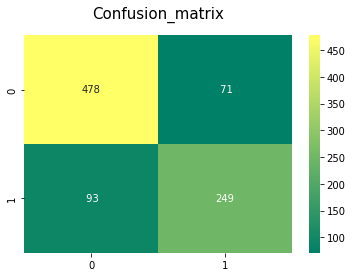

In [33]:
check_model(LDA_model,X_train,y_train,X_test,'LDA model')

In [34]:
evaulate(x_train_all, y_train_all,LDA_model,"LDA model")

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/30 [00:00<?, ?it/s]

Model:  LDA model
Mean cv val score: 0.81
Mean cv val loss 0.19
Mean cv train val score: 0.82
Mean cv train val loss 0.18


In [35]:
show_degree_graphs_cv_train(x_train_all, y_train_all,LDA_model, k=5 ,max_degree=8)   

Poly Degree:   0%|          | 0/7 [00:00<?, ?it/s]

<font size="4">I chose to use the LDA model because it's got the best accuracy and validation results</font>

<font size="5">Finding the best subset of features for this dataset</font>

In [36]:
best_feats = rec_feat_selection(x_train_all, y_train_all).columns

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but RFECV was fitted with feature names



,Pclass,Sex,Age,Fare,Cabin,Title,Age_range,LargeFamily
0,0.827377,-0.737695,-0.531048,-0.502445,-0.446250,-0.707550,-0.392999,-0.273476
1,-1.566107,1.355574,0.670256,0.786845,0.109846,1.235215,0.827078,-0.273476
2,0.827377,1.355574,-0.230722,-0.488854,-0.446250,0.263832,-0.392999,-0.273476
3,-1.566107,1.355574,0.445012,0.420730,0.109846,1.235215,0.827078,-0.273476
4,0.827377,-0.737695,0.445012,-0.486337,-0.446250,-0.707550,0.827078,-0.273476
...,...,...,...,...,...,...,...,...
886,-0.369365,-0.737695,-0.155640,-0.386671,-0.446250,3.177981,-0.392999,-0.273476
887,-1.566107,1.355574,-0.756292,-0.044381,2.890325,0.263832,-0.392999,-0.273476
888,0.827377,1.355574,-0.606129,-0.176263,-0.446250,0.263832,-0.392999,-0.273476
889,-1.566107,-0.737695,-0.230722,-0.044381,0.109846,-0.707550,-0.392999,-0.273476


--------------The Accuracy of the LDA model - selected features ----------------------------
The accuracy is 81.34
The cross validated score is: 81.6


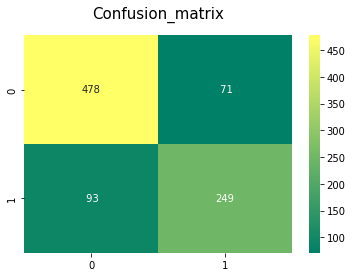

In [37]:
check_model(LDA_model,X_train[best_feats],y_train,X_test[best_feats],'LDA model - selected features')

--------------The Accuracy of the LDA model ----------------------------
The accuracy is 80.22
The cross validated score is: 81.6


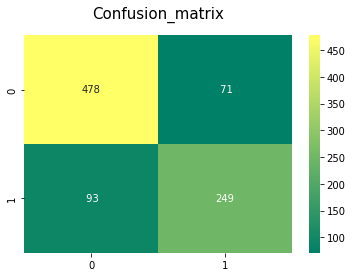

In [38]:
check_model(LDA_model,X_train,y_train,X_test,'LDA model')

<font size="4"> We can see the accuracy and validation scores did not improve by much.</font>
<font size="4"> I decided not to use only the selected features, because the final score of the submission was lower this way.</font>

<font size="5">Finding the best hyper parameters </font>

In [39]:
# train with grid search and get best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

hyper_parameters =  {"solver" : ["svd"],
              "tol" : [0.0001,0.0002,0.0003]}
gs_model = GridSearchCV(LDA_model,param_grid = hyper_parameters, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1).fit(x_train_all,y_train_all)
print('Accuracy score for classification:')
print('gs_model', gs_model.best_score_)
print('best params', gs_model.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Accuracy score for classification:
gs_model 0.815931203314293
best params {'solver': 'svd', 'tol': 0.0001}


<font size="5">Predict results </font>

In [40]:
predict_test = gs_model.predict(x_test_final)

In [41]:
result_csv = pd.DataFrame({"PassengerId": data_test_passenger_id.values,"Survived": predict_test})
result_csv.to_csv("result_csv_exercise_3.csv", index=False)

<font size="5">Summary:</font>  
<font size="4">By comparing and tuning the chosen model, I succeeded to get a good result.</font>   
<font size="4">Unfortunately, the new score is not different from my previous score. It might have been better, if it was allowed to use other different models for this exercise. </font>  
 </font>


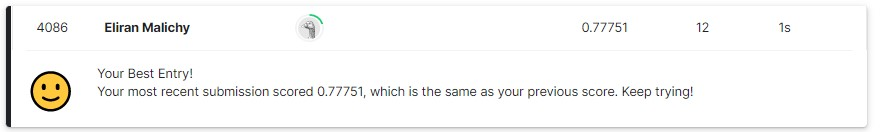

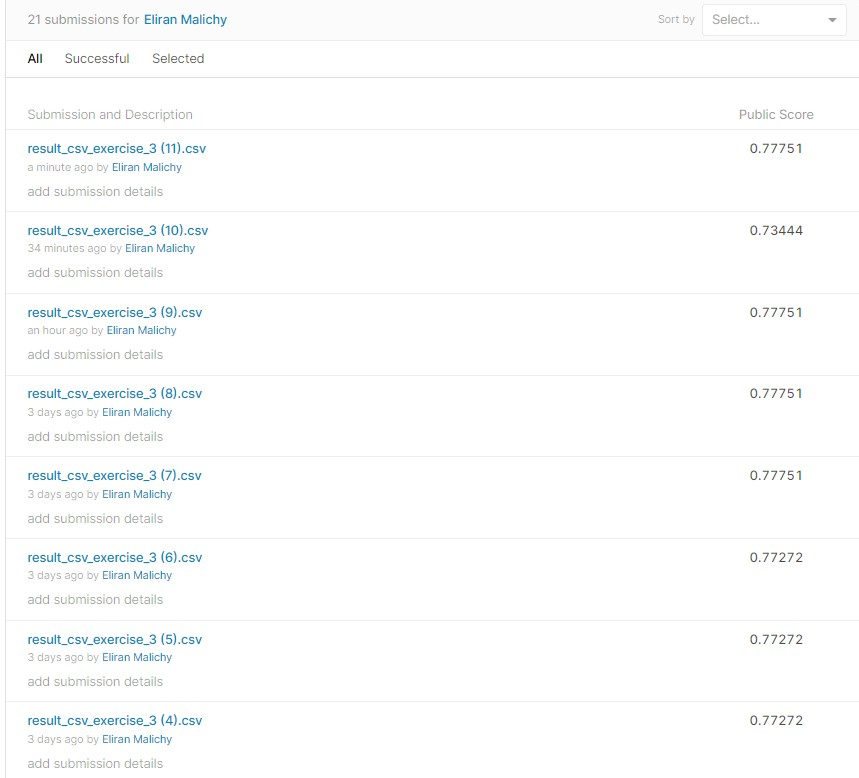

<font size="5">References:</font>  
<font size="3">https://towardsdatascience.com/kaggle-titanic-machine-learning-model-top-7-fa4523b7c40</font>  
<font size="3">https://www.kaggle.com/code/alqwizz89/implicit-data-in-titanic-top-3?scriptVersionId=61344798</font>  
<font size="3">https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/notebook</font>  
<font size="3">https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy/notebook</font>  